# Emotion recognition with DeepFace

Here we use models pre-trained on the FER-2013 dataset for facial analysis (age, gender, race and emotion). The range of emotions predicted is : angry, disgust, fear, happy, sad, surprise, neutral. This implementation of deepface uses Tensorflow.

In [1]:
from img_functions import *
import tensorflow as tf

In [2]:
# Load images
rgb_imgs = load_images()
# Pre-process images
gr_imgs = preproc_fer(rgb_imgs)

# Bulding the model for emotion recognition

The emotion recognition module is an extension of deepface. The pre-trained CNN used can be found here : https://github.com/serengil/deepface/blob/master/deepface/extendedmodels/Emotion.py

In [10]:
# Build pre-trained model and predict
model = DeepFace.build_model('Emotion')
predictions = model.predict(gr_imgs[1], verbose='0')[0,:]
sum_of_predictions = predictions.sum()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 average_pooling2d (AverageP  (None, 7, 7, 64)         0         
 ooling2D)                                                       
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 5, 128)         7

In [10]:
# Display predictions for a single image
labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
list = {}
for i in range(0, len(labels)):
	label = labels[i]
	prediction = 100 * predictions[i] / sum_of_predictions
	list[label] = prediction
print(list)

# DeepFace.analyze(img, actions=['emotion'])

{'angry': 1.0945956319119432e-05, 'disgust': 3.332763969313146e-10, 'fear': 1.4465159736687383e-06, 'happy': 96.45216464996338, 'sad': 8.830248248159478e-05, 'surprise': 0.0001431768851034576, 'neutral': 3.547588363289833}


# Applying GradCAM

In [6]:
# Define the target layer
target_layer = model.get_layer("conv2d_2") # choose any convolution layer
# Build model and separate the target layer outputs (conv_layer.output) from the predictions (model.output)
gradModel = tf.keras.Model(inputs=[model.inputs], outputs=[target_layer.output,model.output])
gradModel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 44, 44, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 average_pooling2d (AverageP  (None, 7, 7, 64)         0         
 ooling2D)                                                 

In [8]:
def gradcam(inputs) :

    # Save the operations during the forward pass in order to compute the gradients using backpropagation 
    with tf.GradientTape() as tape :
        convOutputs, predictions = gradModel(inputs)
        # predictions = predictions[0]
        # convOutputs = convOutputs[0]
        # tape.watch(convOutputs)
        target_category = tf.argmax(predictions[0,:]) # index of highest scoring class
        loss = predictions[:,target_category]

    # Compute gradients of target category score wrt to each feature map
    grads = tape.gradient(loss, convOutputs)

    # Average pool the gradients in order to get the importance weight for each feature map
    # These weights represent the contribution of each feature map to the target category score
    weights = np.mean(grads[0], axis=(0, 1))

    # Compute the ponderation of the contributions
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    # Resize map to input dimensions
    cam = cv2.resize(np.array(cam[0]), (48, 48))

    # Change colormap of gradient map
    # heatmap = cam / np.max(cam)
    # cam = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay original grayscale image with gradient map
    # cam = cam + np.array(inputs[0])[0,:,:,0]

    # Apply ReLU then normalize values
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)

    return cam

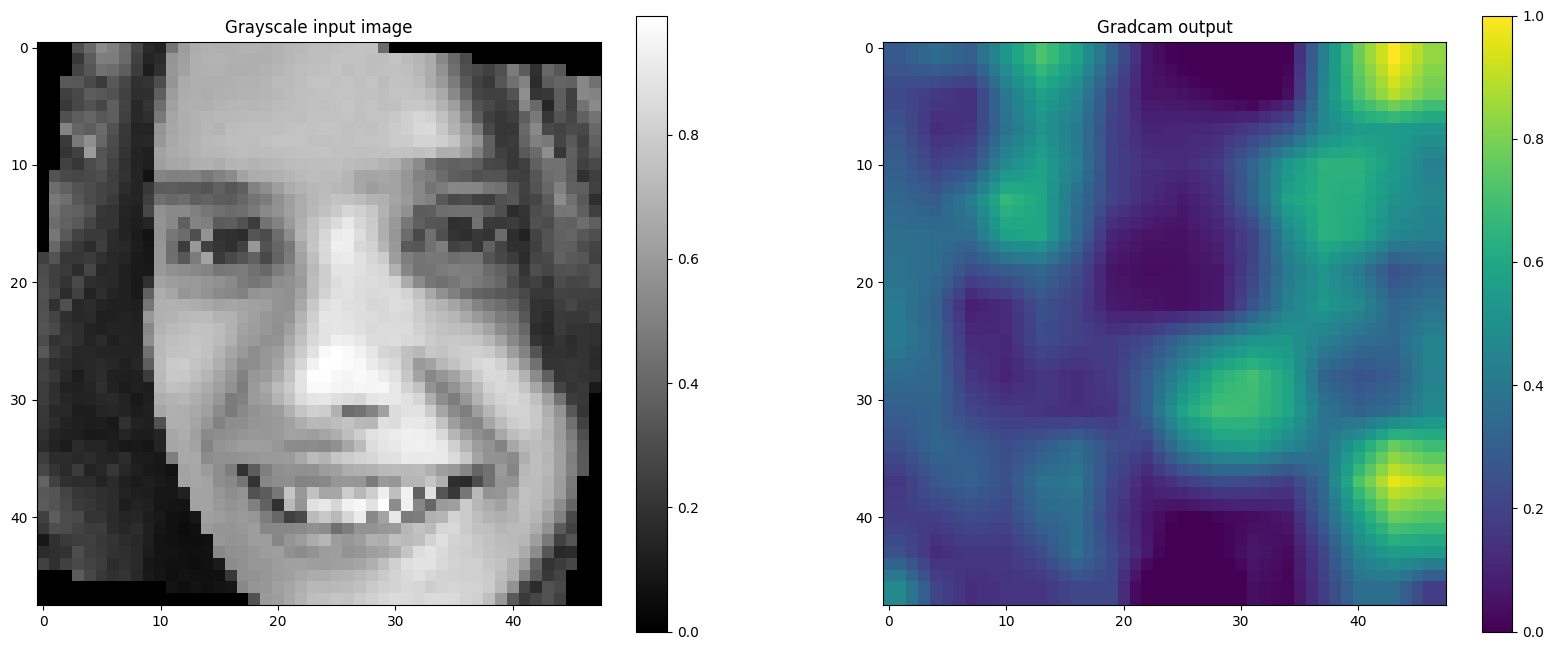

In [11]:
im_test = gr_imgs[2]
cam = gradcam([im_test])
fig, (ax1, ax2) = plt.subplots(figsize=(20,20),ncols=2)
ax1.set_title('Grayscale input image')
original = ax1.imshow(im_test[0], cmap='gray')
fig.colorbar(original, ax=ax1, shrink=0.4)
ax2.set_title('Gradcam output')
explanation = ax2.imshow(cam)
fig.colorbar(explanation, ax=ax2, shrink=0.4)
plt.show()

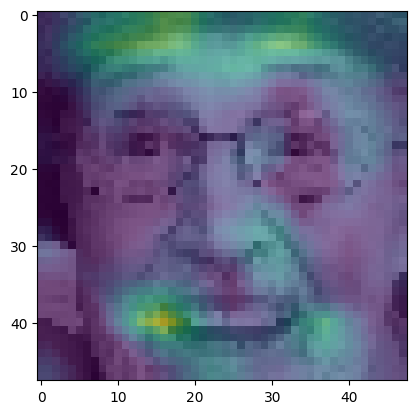

In [75]:
plt.imshow(gr_imgs[9][0], cmap='gray')
plt.imshow(cam, alpha=0.6)
plt.show()

In [1]:
# import matplotlib as mpl

# def plot_colorMaps(cmap):

#     fig, ax = plt.subplots(figsize=(4,0.4))
#     col_map = plt.get_cmap(cmap)
#     mpl.colorbar.ColorbarBase(ax, cmap=col_map, orientation = 'horizontal')

#     plt.show()

# for cmap_id in plt.colormaps():
#     print(cmap_id)
#     plot_colorMaps(cmap_id)

# Using VGG16